# General

In this Jupyter notebook, I will replicate the paper **"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" by Dosovitskiy et al.** with Pytorch. The paper proposes a new approach to image recognition using transformers, a type of neural network commonly used in natural language processing.

**ViT** - Stands for Vision Transformer. Short hand for the original machine learning research paper that introduced the ViT architecture, [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929), anytime ViT paper is mentioned, you can be assured it is referencing this paper.

## What's ViT made of?

1. **Figure 1** - This gives an overview of the model in a graphical sense, you could *almost* recreate the architecture with this figure alone.
2. **Four equations in section 3.1** - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.
3. **Table 1** - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.

### Exploring Figure 1

1. **Layers** - takes an **input**, performs an operation or function on the input, produces an **output**.
2. **Blocks** - a collection of layers, which in turn also takes an **input** and produces an **output**.
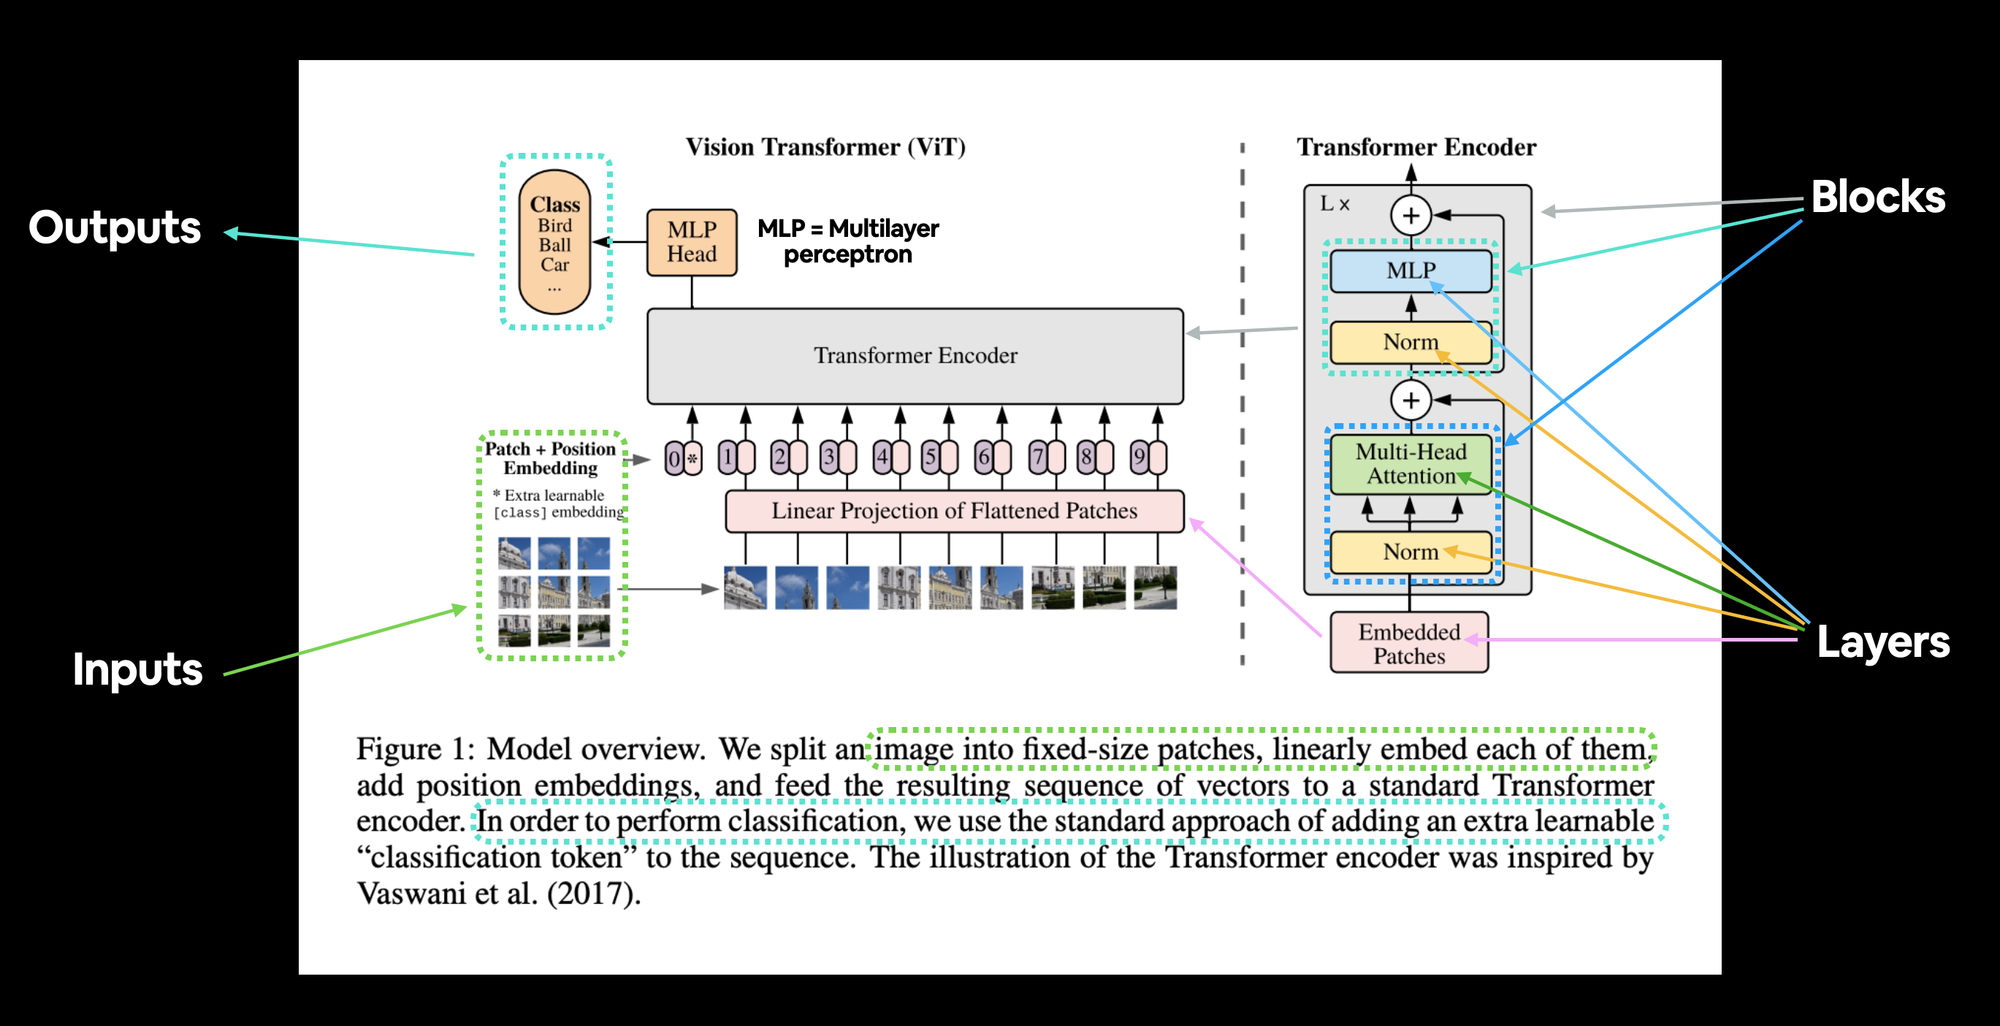

**The ViT architecture is comprised of several stages:**

- **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and add a position number what order the patch comes in.
- **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an **embedding**, the benefit of using an embedding rather than just the image values is that an embedding is a *learnable* representation (typically in the form of a vector) of the image that can improve with training.
- **Norm** - This is short for "[Layer Normalization](https://paperswithcode.com/method/layer-normalization)" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer [torch.nn.LayerNorm()](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html).
- **Multi-Head Attention** - This is a [Multi-Headed Self-Attention layer](https://paperswithcode.com/method/multi-head-attention) or "MSA" for short. You can create an MSA layer via the PyTorch layer [torch.nn.MultiheadAttention()](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html).
- **MLP (or [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron))** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a `forward()` method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two [torch.nn.Linear()](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers with a [torch.nn.GELU()](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) non-linearity activation in between them (section 3.1) and a [torch.nn.Dropout()](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layer after each (Appendex B.1).
- **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
- **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

### Exploring the Four Equations
**Equtions:**
$$\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D}  \qquad \space \space (1) \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \qquad \qquad \qquad \qquad \qquad \space (2) \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\mathrm{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \qquad \qquad \qquad \qquad \qquad \space (3) \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) \quad (4) & &
\end{aligned}$$

**Pseudocode:**
1) ```x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]```
2) ```x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input```
3) ```x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block```
4) ```y = Linear_layer(LN_layer(x_output_MLP_block[0]))```

| Equation number | Description from ViT paper section 3.1 |
| --- | --- |
| 1 | The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings... Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings. | 
| 2 | The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019). |
| 3 | Same as equation 2. |
| 4 | Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches (z0 = xclass), whose state at the output of the Transformer encoder z0L serves as the image representation y (Eq. 4). |

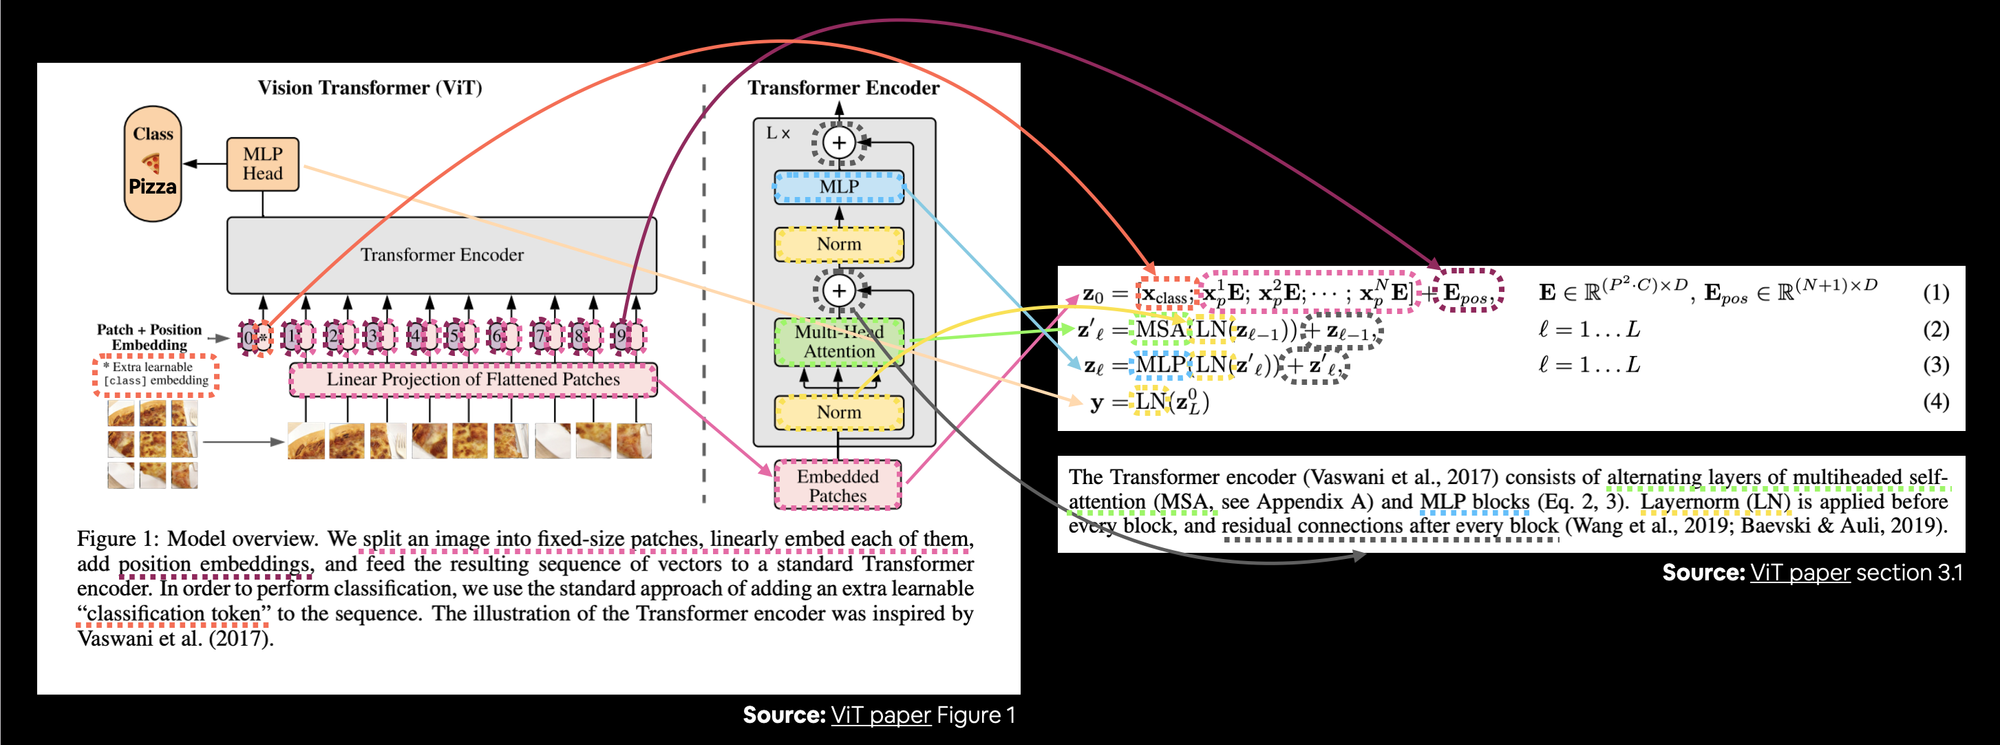

To handle $2 \mathrm{D}$  images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches , where $(H, W)$ is the **resolution** of the original image, $C$ is the **number of channels**,   $(P, P)$ is the **resolution** of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. 

The Transformer uses **constant latent vector** size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Position embeddings** are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$  position embeddings, since we have not observed significant performance
gains from using more advanced $2 \mathrm{D}$-aware position embeddings. The resulting sequence of embedding vectors serves as **input** to the encoder.

### Exploring Table 1 (various hyperparameters of each of the ViT architectures)

| Model | Layers | Hidden size D | MLP size | Heads | Params |
| --- | --- | --- | --- | --- | --- |
ViT-Base|12|768|3072|12|86M
ViT-Large|24|1024|4096|16|307M
ViT-Huge|32|1280|5120|16|632M

**Breaking the hyperparameters down:**
- **Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)
- **Hidden size D** - This is the embedding dimension throughout the architecture, this will be the size of the vector that image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.
- **MLP size** - What are the number of hidden units in the MLP layers?
- **Heads** - How many heads are there in the Multi-Head Attention layers?
- **Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

# Preparation

This chapter will contain code for creating modular Python files for next tasks:
- **Data downloading** - for downloading data -```data_downloader.py```
- **Helper functions** for training, visualizations etc. - ```utils.py```
- **ViT** contains ViT architecture - ```engine.py```
- **Train script** - for train model - ```train.py```
- **Feauture extractor script** - for train feauture extractor - ```train_extractor.py```

## Data downloading script
For this task i decided to use open dataset from Kaggle called [Animals-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10?resource=download), contains images with ten different animals.

In [1]:
%%writefile data_download.py
import os
import sys
import pathlib
import argparse
import zipfile
import shutil
from kaggle.api.kaggle_api_extended import KaggleApi

from tqdm import tqdm

# Create a parser
parser = argparse.ArgumentParser(description="Get some hyperparameters.")

# Get an arg for train_sizefolder with data
parser.add_argument("--data_folder", 
                     default='data', 
                     type=str, 
                     help="the name of folder with data")

# Get an arg dataset_key
parser.add_argument("--dataset_key", 
                     default='alessiocorrado99/animals10',
                     type=str,
                     help="the dataset key of Kaggle datasets")

# Get an arg for kaggle_username
parser.add_argument("--kaggle_username", 
                     type=str, 
                     help="the Kaggle username")

# Get an arg for train_sizefolder with datakaggle_api
parser.add_argument("--kaggle_api",
                     type=str, 
                     help="the Kagggle api")

# Get our arguments from the parser
args = parser.parse_args()

# Setup hyperparameters
DATA_PATH = args.data_folder
DATASET_KEY = args.dataset_key
KAGGLE_USERNAME = args.kaggle_username
KAGGLE_API = args.kaggle_api


def data_downloader(dataset_key=DATASET_KEY,
                    kaggle_username=KAGGLE_USERNAME,
                    kaggle_api=KAGGLE_API):
    '''
    Downloads data from Kaggle, creates new directories,
    and deletes old files
    '''
    data_path = pathlib.Path(DATA_PATH)
    
    # Check if directory 'data' in repository
    if data_path.is_dir() == False: # change to false
        
        
        # Setting Kaggle environment
        try:
            os.environ['KAGGLE_USERNAME'] = kaggle_username
        except TypeError as username_error:
            sys.exit("You should specify Kaggle username: --kaggle_username <your username>")
            
            
        try:
            os.environ['KAGGLE_KEY'] = kaggle_api
        except TypeError as api_error:
            sys.exit("You should specify Kaggle api: --kaggle_api <your api>")

        api = KaggleApi()
        api.authenticate()
        
        # Creating folder for data
        os.mkdir(DATA_PATH)
        print(f"There are no have directory {DATA_PATH}', creating new one")
        
        with tqdm(total=100) as t:
            # Download data from Kaggle 
            print('Downloading data...')
            api.dataset_download_files(dataset_key, path=data_path)
            print('Data has downloaded')
        
        with tqdm(total=100) as t:
            # Getting name of archive
            zip_path = list(data_path.glob('*.zip'))[0]
            # Extracting files from archive
            print('Extracting files from archive...')
            with zipfile.ZipFile(zip_path, 'r') as zip_file:
                zip_file.extractall(data_path)
            print('Files has extracted')

            # Deleting zipfile
            try:
                os.remove(zip_path)
            except PermissionError as ex:
                print(f"Couldn't delete zip file for {ex}")

        # Check if data_path doesn't contain additional directories inside and deleting if does
        list_of_dirs_in_data = [file for file in data_path.iterdir() if file.is_dir()]
        print(list_of_dirs_in_data)
        if len(list_of_dirs_in_data) == 1:
            added_dir_path = list_of_dirs_in_data[0]
            
            list_of_dirs_in_added_dir = os.listdir(added_dir_path)
            
            # Looping through each folder in added dir and moving to data_path
            for image_class in list_of_dirs_in_added_dir:
                original_path = added_dir_path / image_class
                print('Orig', original_path)
                
                new_path = data_path / image_class
                print('new_path', new_path)
                # Moving files
                shutil.move(original_path, new_path)
            print('Folders has removed')
            
            # Deleting emptyExceptionded folder
            try:
                os.remove(added_dir_path)
            except PermissionError as ex:
                print(f"Couldn't delete added dir path for {ex}")
        
        # Checking presence of translate file to rename folders and renaming them
        translate_file_path = data_path / 'translate.py'
        if translate_file_path.is_file():
            # Importing dict with translation
            from data.translate import translate
            # Adding missing key
            translate['ragno'] = 'spider'
            translate['raw-img'] = 'raw-img'
            translate['__pycache__'] = '__pycache__'
            
            # Creating list with folders
            list_of_dirs_in_data = [file for file in data_path.iterdir() if file.is_dir()]
            # Looping through folders in data_path and rename folders
            for folder in list_of_dirs_in_data:
                folder.rename(data_path / translate[folder.name])
                print('Name of folders has renamed')
                
            try:
                os.remove(data_path/'translate.py')
            except PermissionError as ex:
                print(f"Couldn't delete translate.py for {ex}")

    else:
        print("The repository has directory 'data'")

if __name__ == '__main__':
    data_downloader()

Overwriting data_download.py


## Utils script

This script contains several functions for creating dataloaders, training, visualisations

In [2]:
%%writefile utils.py
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def make_dataloaders(data_path, 
                     train_size=0.85,
                     test_size=0.15,
                     batch_size=32,
                     limit_size=False):
    '''
    Creates train and test dataloaders
    '''
    # Defining num workers
    num_workers = os.cpu_count()
    
    # Creating transformer to transform data
    transformer = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor()
        ])
    
    # Creating train and test dataset
    full_dataset = datasets.ImageFolder(root=data_path,
                                        transform=transformer)
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
    
    # Limit size of datasets
    if limit_size:
        train_dataset = torch.utils.data.Subset(train_dataset, list(range(500)))
        test_dataset = torch.utils.data.Subset(test_dataset, list(range(500)))

    # Creating train and test dataloader
    train_dataloader = DataLoader(dataset=train_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=num_workers,
                                 pin_memory=True)
    
    test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers,
                                pin_memory=True)
    
    return train_dataloader, test_dataloader, full_dataset.classes, full_dataset.class_to_idx


def visualize_dataloader_images(dataloader,
                                classes=None,
                                nrows=4,
                                ncols=4):
    '''
    Visualizes random images from DataLoader
    '''
    # Taking one batch and one label
    batch, label = next(iter(dataloader))
    
    # Create a nrows*ncols grid of subplots
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    
    # Subplotting
    for i in range(nrows):
        for j in range(ncols):
            random_index = torch.randint(32, size=(1,))[0]
            image = batch[random_index]
            axs[i, j].imshow(image.permute(1, 2, 0))
            axs[i, j].axis('off')
            
            if classes is not None:
                axs[i, j].set_title(classes[label[random_index]])
                
    plt.tight_layout()
    plt.show()
    

def plot_patchified_image(image, patch_size):
    '''
    Plots patched image
    '''
    # Permuting image
    image_permuted = image.permute(1, 2, 0)
    
    # Setting image size (image always square) and num_patches
    image_size = image_permuted.shape[0]
    num_patches = int(image_size / patch_size)
    
    # Check if image size is divided without remainder
    assert image_size % patch_size == 0
    
    figs, axs = plt.subplots(nrows=int(image_size / patch_size),
                            ncols=int(image_size / patch_size),
                            figsize=(num_patches, num_patches),
                            sharex=True,
                            sharey=True)
    
    for i, patch_height in enumerate(range(0, image_size, patch_size)):
        for j, patch_width in enumerate(range(0, image_size, patch_size)):
            # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
            axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                             patch_width:patch_width+patch_size, :])
            
            # Set up label information, remove the ticks for clarity and set labels to outside
            axs[i, j].set_ylabel(i+1, 
                                 rotation="horizontal", 
                                 horizontalalignment="right", 
                                 verticalalignment="center") 
            axs[i, j].set_xlabel(j+1) 
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].label_outer()
    
    # Set a super title
    figs.suptitle("Patchified image", fontsize=16)
    plt.show()
    

def plot_image_out_of_conv(image, k=5):
    '''
    Plots patchified image by a convolutional layer
    '''
    # Instantiate k random indexes
    random_indexes = random.sample(range(0, 758), k=k)
    
    figs, axs = plt.subplots(nrows=1, ncols=k)
    
    for i, idx in enumerate(random_indexes):
        # Taking random image and prepare it for plotting
        random_image = image[:, idx, :, :].squeeze().detach().numpy()
        # Plotting each subplot
        axs[i].imshow(random_image)
        # Deleting labels, ticks
        axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);
        
    
import matplotlib.pyplot as plt

def plot_image_out_of_flat(flattened_image):
    '''
    Plots flattened feauture map
    '''
    # Permute, taking single map and detach image
    single_flatten_map = flattened_image.permute(0, 2, 1)[:, :, 0].detach().numpy()
    
    # Change figsize
    plt.figure(figsize=(20, 20))
    plt.imshow(single_flatten_map)
    plt.axis('off');

    

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """
    Trains a PyTorch model for a single epoch.
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """
    Tests a PyTorch model for a single epoch.
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc    

    
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """
    Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results


def plot_loss_curves(results):
    """
    Plots training curves of a results dictionary.
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    
    
def pred_and_plot_image(model,
                        class_names,
                        image_path,
                        image_size = (224, 224),
                        transform = None,
                        device = 'cuda' if torch.cuda.is_available else 'cpu'):
    """
    Predicts on a target image with a target model.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

Overwriting utils.py


## Engine script

This script contains classes with model replicating

In [3]:
%%writefile engine.py
import torch
from torch import nn

# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels=3,
                 patch_size=16,
                 embedding_dim=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)
        
        # 5. Define patch_size
        self.patch_size = patch_size

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
    
    
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output
    
    
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x
    
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x
    
    
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

Overwriting engine.py


## Train script

The script need for train model from shell

In [4]:
%%writefile train.py
# train.py
import os
import pathlib
import argparse

import torch

from utils import make_dataloaders
from utils import train
from engine import ViT


# Create a parser
parser = argparse.ArgumentParser(description="Get some hyperparameters.")

# Get an arg for epochs
parser.add_argument("--epochs", 
                     default=10, 
                     type=int, 
                     help="the number of epochs to train for")

# Get an arg for batch_size
parser.add_argument("--batch_size", 
                     default=32, 
                     type=int, 
                     help="the number of batch size to train for")

# Get an arg for lr
parser.add_argument("--lr", 
                     default=0.001, 
                     type=float, 
                     help="the learning rate to train for")

# Get an arg for train_size
parser.add_argument("--train_size", 
                     default=0.85, 
                     type=float, 
                     help="the ratio of data for training dataset")

# Get an arg for test_size
parser.add_argument("--test_size", 
                     default=0.15, 
                     type=float, 
                     help="the ratio of data for test dataset")

# Get an arg for train_sizefolder with data
parser.add_argument("--data_folder", 
                     default='data', 
                     type=str, 
                     help="the name of folder with data")


# Get our arguments from the parser
args = parser.parse_args()

# Setup hyperparameters
NUM_EPOCHS = args.epochs
LEARNING_RATE = args.lr
BATCH_SIZE = args.batch_size
TRAIN_SIZE = args.train_size
TEST_SIZE = args.test_size
DATA_PATH = pathlib.Path(args.data_folder)
SAVE_MODEL_PATH = pathlib.Path('models/vit_model.pth')


def main():
    # Set device
    device = 'cuda' if torch.cuda.is_available else 'cpu'
    print(f"Using device is {device}.")
    
    # Create train and test dataloaders
    train_dataloader, test_dataloader, classes, class_to_idx = make_dataloaders(data_path=DATA_PATH,
                                                                               train_size=TRAIN_SIZE,
                                                                               test_size=TEST_SIZE,
                                                                               batch_size=BATCH_SIZE,
                                                                               limit_size=False)
    
    print(f"Length of train_dataloader is {len(train_dataloader)}.\
        \nLength of test_dataloader is {len(test_dataloader)}.")
    
    
    # Instantiation ViT
    vit = ViT(num_classes=len(classes))
    
    # Creating an optimizer
    optimizer = torch.optim.Adam(params=vit.parameters(), 
                                 lr=LEARNING_RATE,
                                 betas=(0.9, 0.999),
                                 weight_decay=0.3)
    
    # Setup the loss function for multi-class classification
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Train the model and save the training results to a dictionary
    results = train(model=vit,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=NUM_EPOCHS,
                    device=device)
    
    # Save model
    torch.save(vit.state_dict(), SAVE_MODEL_PATH)
    print('Model was saved')

if __name__ == '__main__':
    main()

Overwriting train.py


## Train feauture extractor model

In [5]:
%%writefile train_extractor.py
# train_extractor.py
import os
import pathlib
import argparse

import torch
from torch import nn
import torchvision

from utils import make_dataloaders
from utils import train



# Create a parser
parser = argparse.ArgumentParser(description="Get some hyperparameters.")

# Get an arg for epochs
parser.add_argument("--epochs", 
                     default=10, 
                     type=int, 
                     help="the number of epochs to train for")

# Get an arg for batch_size
parser.add_argument("--batch_size", 
                     default=32, 
                     type=int, 
                     help="the number of batch size to train for")

# Get an arg for lr
parser.add_argument("--lr", 
                     default=0.001, 
                     type=float, 
                     help="the learning rate to train for")

# Get an arg for train_size
parser.add_argument("--train_size", 
                     default=0.85, 
                     type=float, 
                     help="the ratio of data for training dataset")

# Get an arg for test_size
parser.add_argument("--test_size", 
                     default=0.15, 
                     type=float, 
                     help="the ratio of data for test dataset")

# Get an arg for train_sizefolder with data
parser.add_argument("--data_folder", 
                     default='data', 
                     type=str, 
                     help="the name of folder with data")


# Get our arguments from the parser
args = parser.parse_args()

# Setup hyperparameters
NUM_EPOCHS = args.epochs
LEARNING_RATE = args.lr
BATCH_SIZE = args.batch_size
TRAIN_SIZE = args.train_size
TEST_SIZE = args.test_size
DATA_PATH = pathlib.Path(args.data_folder)
SAVE_PRETRAINED_MODEL_PATH = pathlib.Path('models/pretrained_vit_model.pth')


def main():
    # Set device
    device = 'cuda' if torch.cuda.is_available else 'cpu'
    print(f"Using device is {device}.")
    
    # Create train and test dataloaders
    train_dataloader, test_dataloader, classes, class_to_idx = make_dataloaders(data_path=DATA_PATH,
                                                                               train_size=TRAIN_SIZE,
                                                                               test_size=TEST_SIZE,
                                                                               batch_size=BATCH_SIZE,
                                                                               limit_size=False)
    
    print(f"Length of train_dataloader is {len(train_dataloader)}.\
        \nLength of test_dataloader is {len(test_dataloader)}.")
    
    
    # Get pretrained weights for ViT-Base
    pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    
    # Setup a ViT model instance with pretrained weights
    pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)
    
    # Freeze the base parameters
    for parameter in pretrained_vit.parameters():
        parameter.requires_grad = False
    
    # Change the classifier head (set the seeds to ensure same initialization with linear head)
    pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(classes)).to(device)
    
    # Creating an optimizer
    optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                                 lr=LEARNING_RATE,
                                 betas=(0.9, 0.999),
                                 weight_decay=0.3)
    
    # Setup the loss function for multi-class classification
    loss_fn = torch.nn.CrossEntropyLoss()
    
    # Train the model and save the training results to a dictionary
    results = train(model=pretrained_vit,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=NUM_EPOCHS,
                    device=device)
    
    # Save model
    torch.save(pretrained_vit.state_dict(), SAVE_PRETRAINED_MODEL_PATH)
    print('Model was saved')

if __name__ == '__main__':
    main()

Overwriting train_extractor.py


# Preparing for replicating paper

## Instantiation constant variables

In [6]:
import pathlib

DATA_PATH = pathlib.Path('data')
BATCH_SIZE=32
TRAIN_SIZE = 0.85
TEST_SIZE=0.15

In [7]:
import torch

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(f"Using device is {device}.")

Using device is cuda.


## Create train and test dataloaders

In [8]:
from utils import make_dataloaders
train_dataloader, test_dataloader, classes, class_to_idx = make_dataloaders(data_path=DATA_PATH,
                                                                           train_size=TRAIN_SIZE,
                                                                           test_size=TEST_SIZE,
                                                                           batch_size=BATCH_SIZE)
print(f"Length of train_dataloader is {len(train_dataloader)}.\
        \nLength of test_dataloader is {len(test_dataloader)}.")

Length of train_dataloader is 696.        
Length of test_dataloader is 123.


### Taking batches for next replicating

In [9]:
image_batch, label_batch = next(iter(train_dataloader))
print(f"Shape of image_batch is {tuple(image_batch.shape)}\
        \nShape of label_batch is {tuple(label_batch.shape)}")

Shape of image_batch is (32, 3, 224, 224)        
Shape of label_batch is (32,)


### Taking one image and one label from batch for next replicating

In [10]:
image, label = image_batch[0], label_batch[0]
print(f"Shape of image is {tuple(image.shape)}\
        \nLabel is equal {label}")

Shape of image is (3, 224, 224)        
Label is equal 5


## Vizualize random images from DataLoader

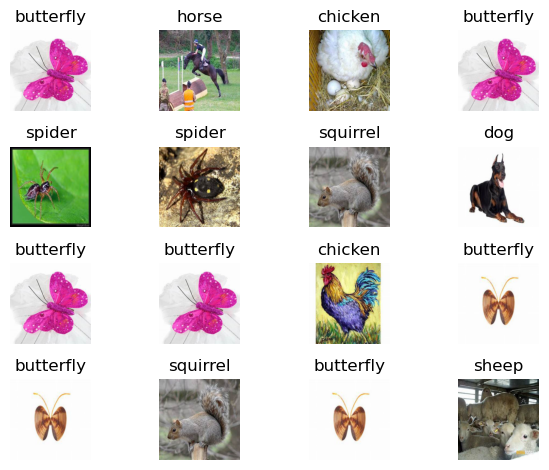

In [11]:
from utils import visualize_dataloader_images
visualize_dataloader_images(train_dataloader, classes=classes)

## Replicating ViT

**Let's break down the text above.**

- $\mathrm{D}$ is the size of the **patch embeddings**
- The image starts as $2 \mathrm{D}$ with size  $H×W×C$.
    - $H, W$ is the resolution of the original image **(height, width).**
    - $C$ is the number of channels.
- The image gets converted to a sequence of flattened $2 \mathrm{D}$ patches with size $N×(P^2⋅C)$.
    - $(P,P)$ is the resolution of each image patch (**patch size**).
    - $N=HW/P^2$  is the resulting number of patches, which also serves as the input sequence length for the Transformer.

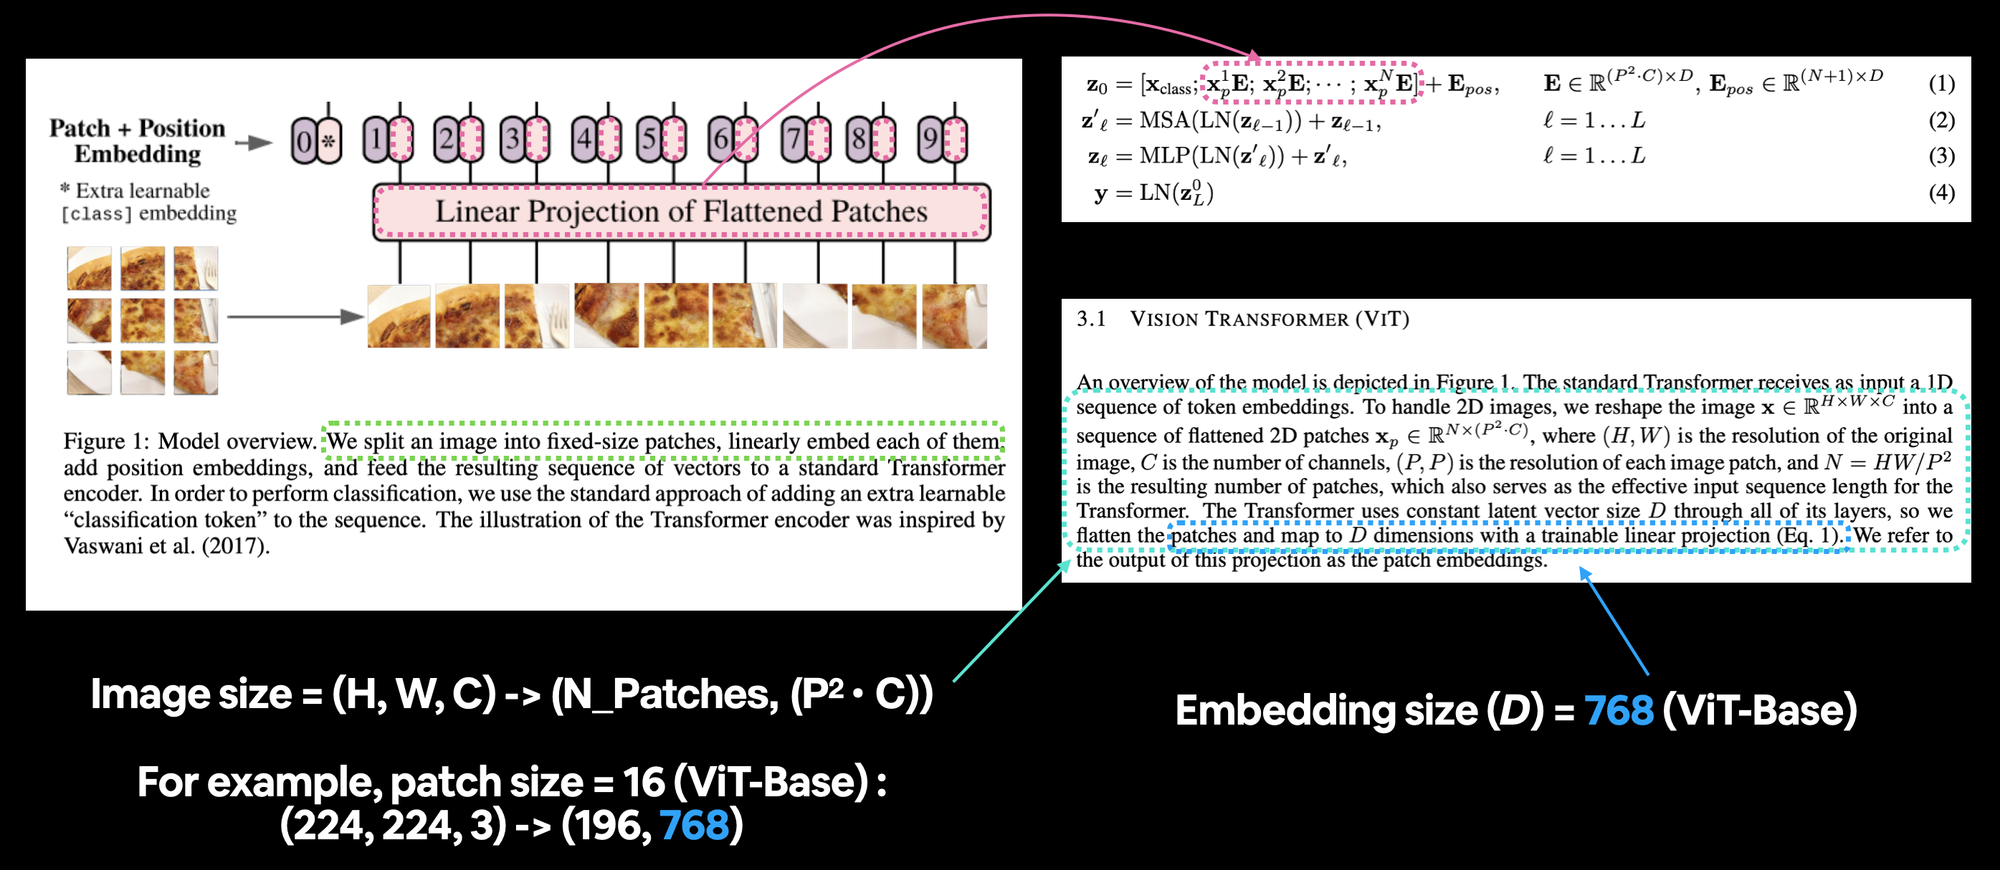

### Instantiate variables

In [12]:
color_channels, height, width = image.shape

patch_size = 16
number_of_patches = int(height*width / patch_size**2)

print(f"Number of patches with image with shape {color_channels, height, width} and patch size {patch_size} is {number_of_patches}")

Number of patches with image with shape (3, 224, 224) and patch size 16 is 196


In [13]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


### Turning image into patches, split data into patches and creating the class, position and patch embedding

#### Visualise image patches

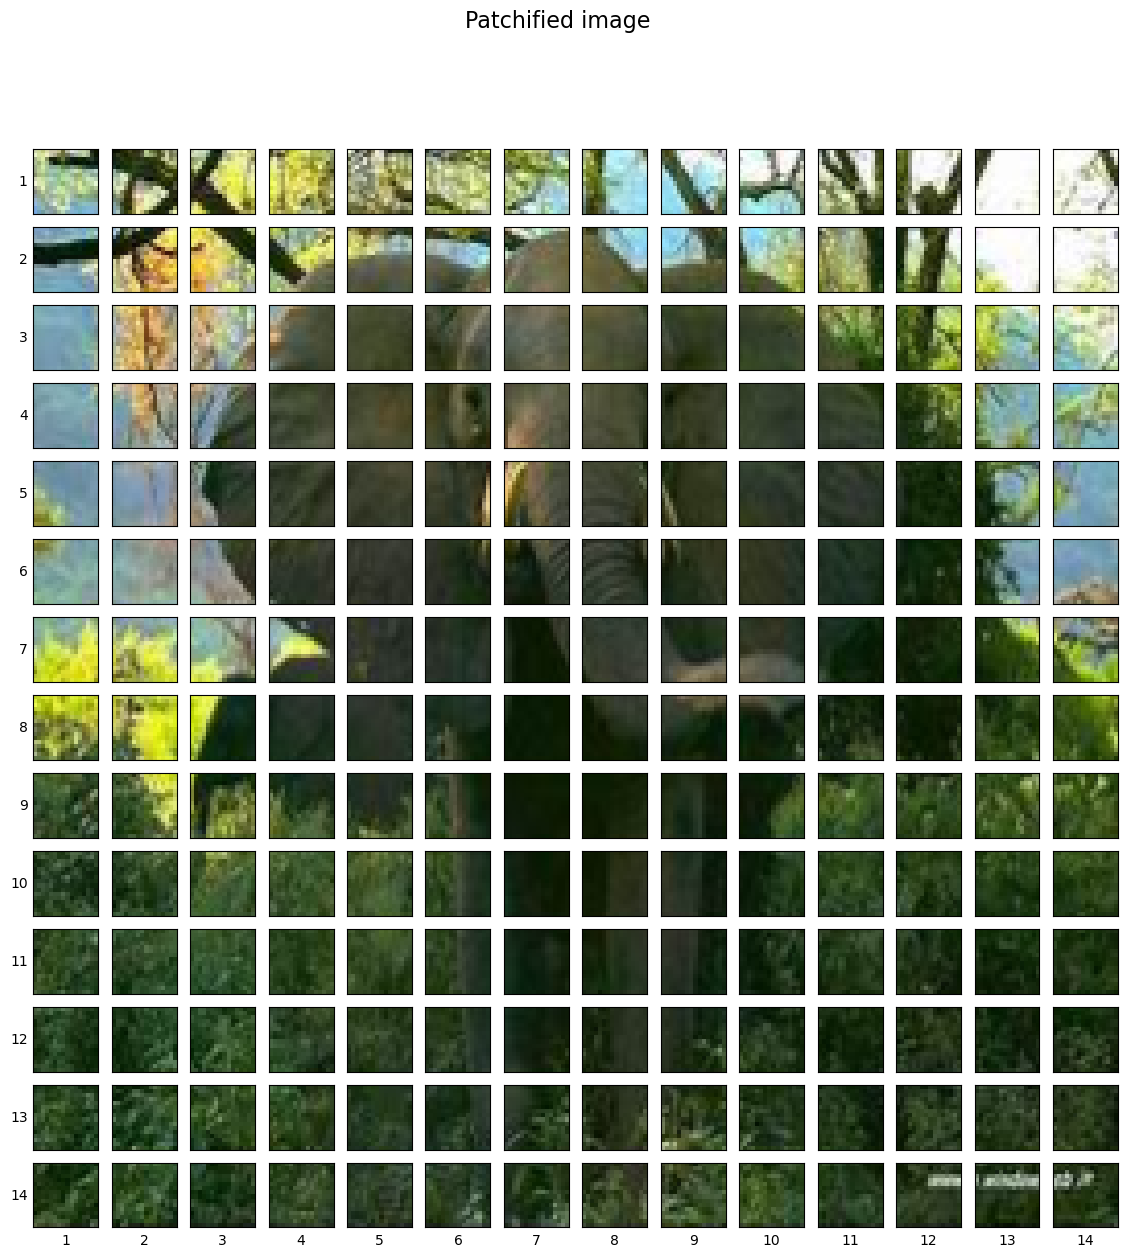

In [14]:
from utils import plot_patchified_image
plot_patchified_image(image, patch_size)

#### Creating image patches with torch.nn.Conv2d()

In [15]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

**Pass the image through the convolutional layer**

In [16]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


**Visualize image patches**

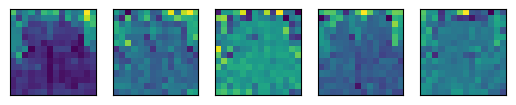

In [17]:
from utils import plot_image_out_of_conv
plot_image_out_of_conv(image_out_of_conv)

**Get a single feauture map**

In [18]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad # -> torch.Size([1, 196])

(tensor([[[ 0.0818,  0.0823,  0.1781,  0.2230,  0.2221,  0.2850,  0.1995,
            0.1417, -0.0342,  0.2757,  0.1430,  0.5344,  0.4251,  0.3087],
          [ 0.1521,  0.1728,  0.3087,  0.0928,  0.1513,  0.2212,  0.1348,
            0.1731,  0.3357,  0.4553,  0.2723,  0.3016,  0.4462,  0.3777],
          [ 0.2696,  0.1580,  0.2249,  0.1580,  0.1227,  0.1868,  0.2321,
            0.1320,  0.1274,  0.1569,  0.2353,  0.1313,  0.3048,  0.2312],
          [ 0.2272,  0.1554,  0.2790,  0.1247,  0.1082,  0.1363,  0.1777,
            0.0916,  0.0909,  0.1210,  0.0983,  0.0812,  0.3537,  0.2402],
          [ 0.2495,  0.2522,  0.1154,  0.1316,  0.1239,  0.0979,  0.0758,
            0.0803,  0.0707,  0.1051,  0.0900,  0.0465,  0.0677,  0.2665],
          [ 0.2008,  0.2643,  0.1645,  0.1201,  0.1224,  0.1070,  0.1196,
            0.1157,  0.0733,  0.0992,  0.0971,  0.0622,  0.2668,  0.2707],
          [ 0.2246,  0.3062,  0.2762,  0.2875,  0.0993,  0.0608,  0.0156,
            0.0908,  0.1243,  0.

The grad_fn output of the single_feature_mapand the requires_grad=Trueattribute means PyTorch is tracking the gradients of this feature map and it will be updated by gradient descent during training.

#### Flatten image for right shape

**Create flatten layer**

In [19]:
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

In [20]:
image_out_of_flatten = flatten(image_out_of_conv)
image_out_of_flatten.shape

torch.Size([1, 768, 196])

**Visualize flattened feauture map**

In [21]:
from utils import plot_image_out_of_flat
plot_image_out_of_flat(image_out_of_flatten)

#### Turning the ViT patch embedding layer into a PyTorch module

**What should do for it:**

1. Create a class called `PatchEmbedding` which subclasses `nn.Module` (so it can be used a PyTorch layer).
2. Initialize the class with the parameters `in_channels=3`, `patch_size=16` (for ViT-Base) and `embedding_dim=768` (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using `nn.Conv2d()` .
4. Create a layer to flatten the patch feature maps into a single dimension.
5. Define a `forward()` method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture $(N×(P2⋅C))$.

In [22]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels=3,
                 patch_size=16,
                 embedding_dim=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

**Let's try it out on a single image:**

In [23]:
# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


**Get summary of model**

In [24]:
from torchinfo import summary
summary(patchify)

Layer (type:depth-idx)                   Param #
PatchEmbedding                           --
├─Conv2d: 1-1                            590,592
├─Flatten: 1-2                           --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0

### Creating the class token embedding

Making learnable class token embedding

In [25]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


Now we've got the class token embedding, let's prepend it to sequence of image patches, `patch_embedded_image`.

In [26]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.6074,  0.0937,  0.0251,  ...,  0.3968,  0.7042, -0.1214],
         [ 0.7266,  0.1033, -0.1344,  ...,  0.0110,  0.3712,  0.0696],
         ...,
         [ 0.3414,  0.0985, -0.0220,  ...,  0.1659,  0.2524,  0.0640],
         [ 0.2853,  0.1426,  0.0452,  ...,  0.1721,  0.1194, -0.0912],
         [ 0.2488,  0.1289,  0.0728,  ...,  0.0543,  0.1069, -0.0851]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


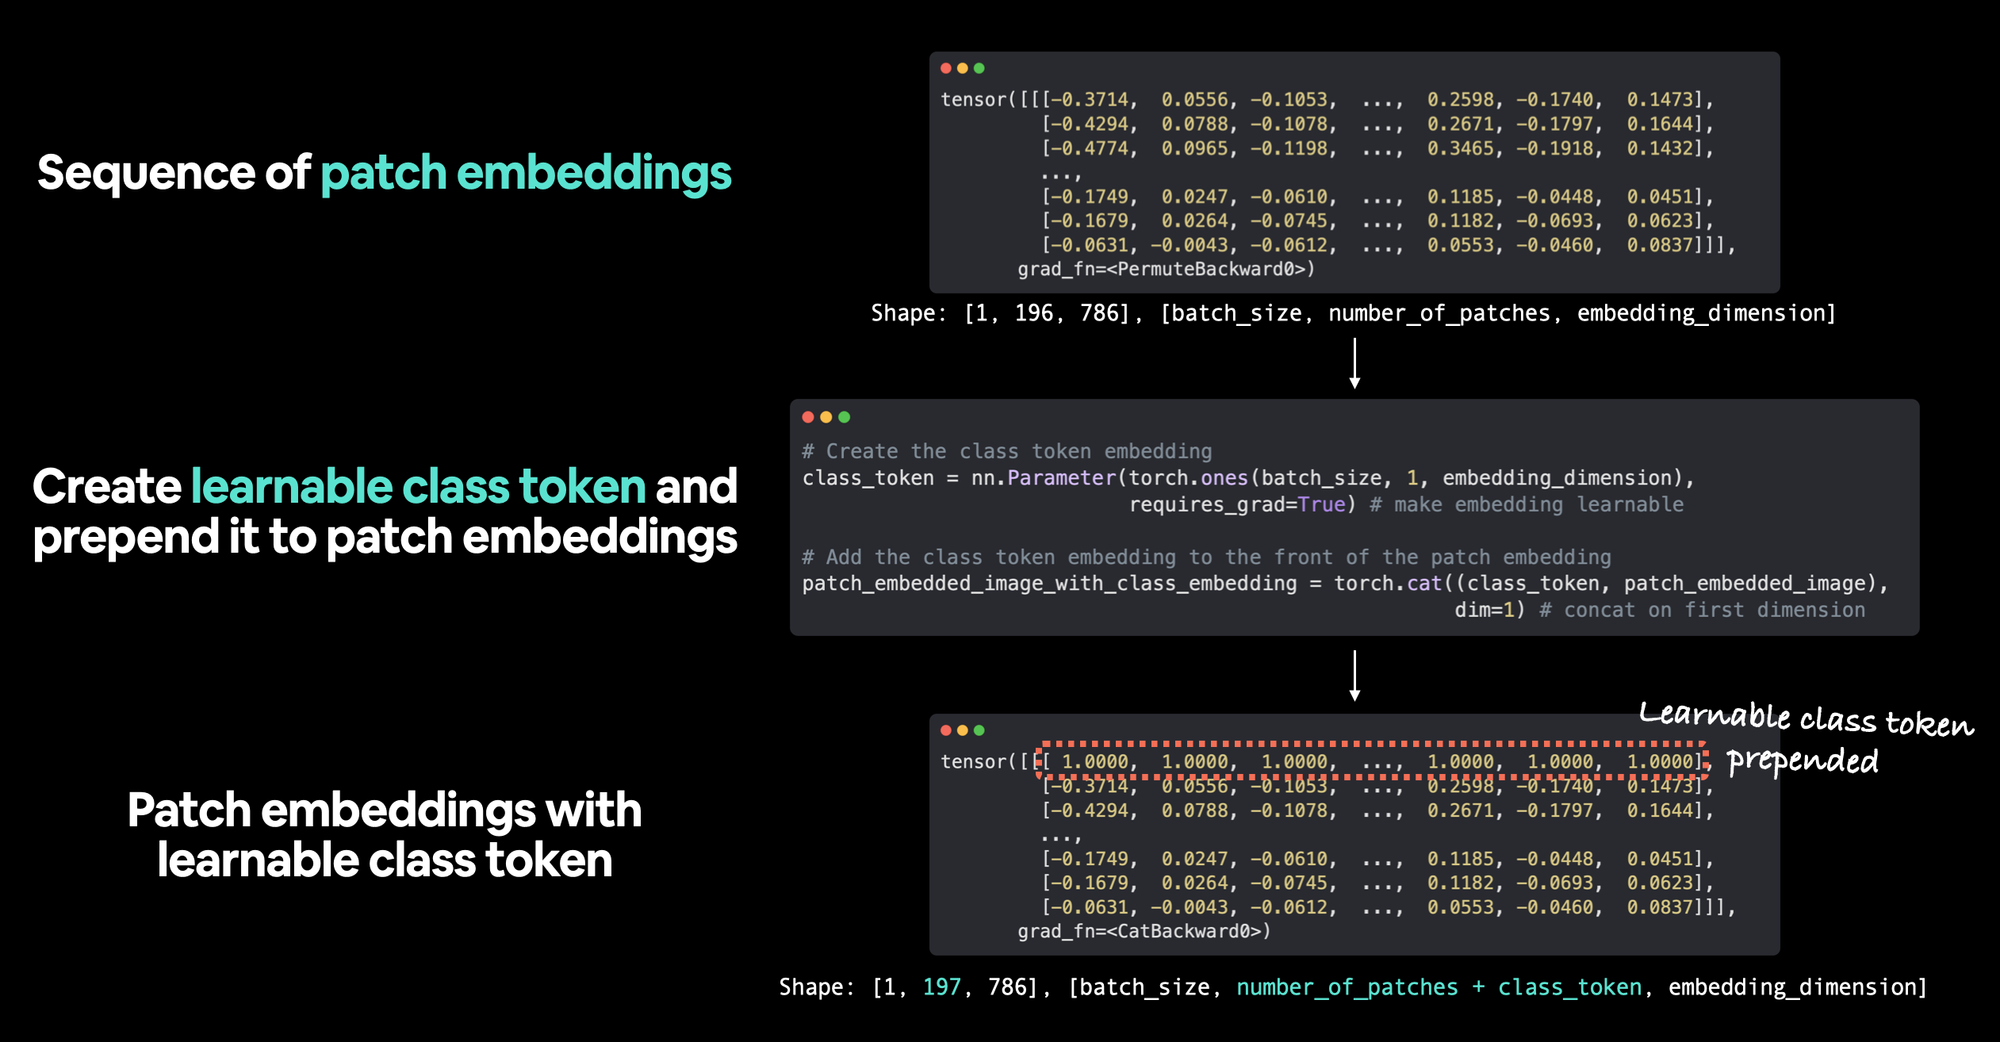

### Creating the position embedding

Making learnable position embedding

In [27]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                  number_of_patches+1, 
                                  embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Let's add them to sequence of patch embeddings with a prepended class token.

In [28]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.6074, 1.0937, 1.0251,  ..., 1.3968, 1.7042, 0.8786],
         [1.7266, 1.1033, 0.8656,  ..., 1.0110, 1.3712, 1.0696],
         ...,
         [1.3414, 1.0985, 0.9780,  ..., 1.1659, 1.2524, 1.0640],
         [1.2853, 1.1426, 1.0452,  ..., 1.1721, 1.1194, 0.9088],
         [1.2488, 1.1289, 1.0728,  ..., 1.0543, 1.1069, 0.9149]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


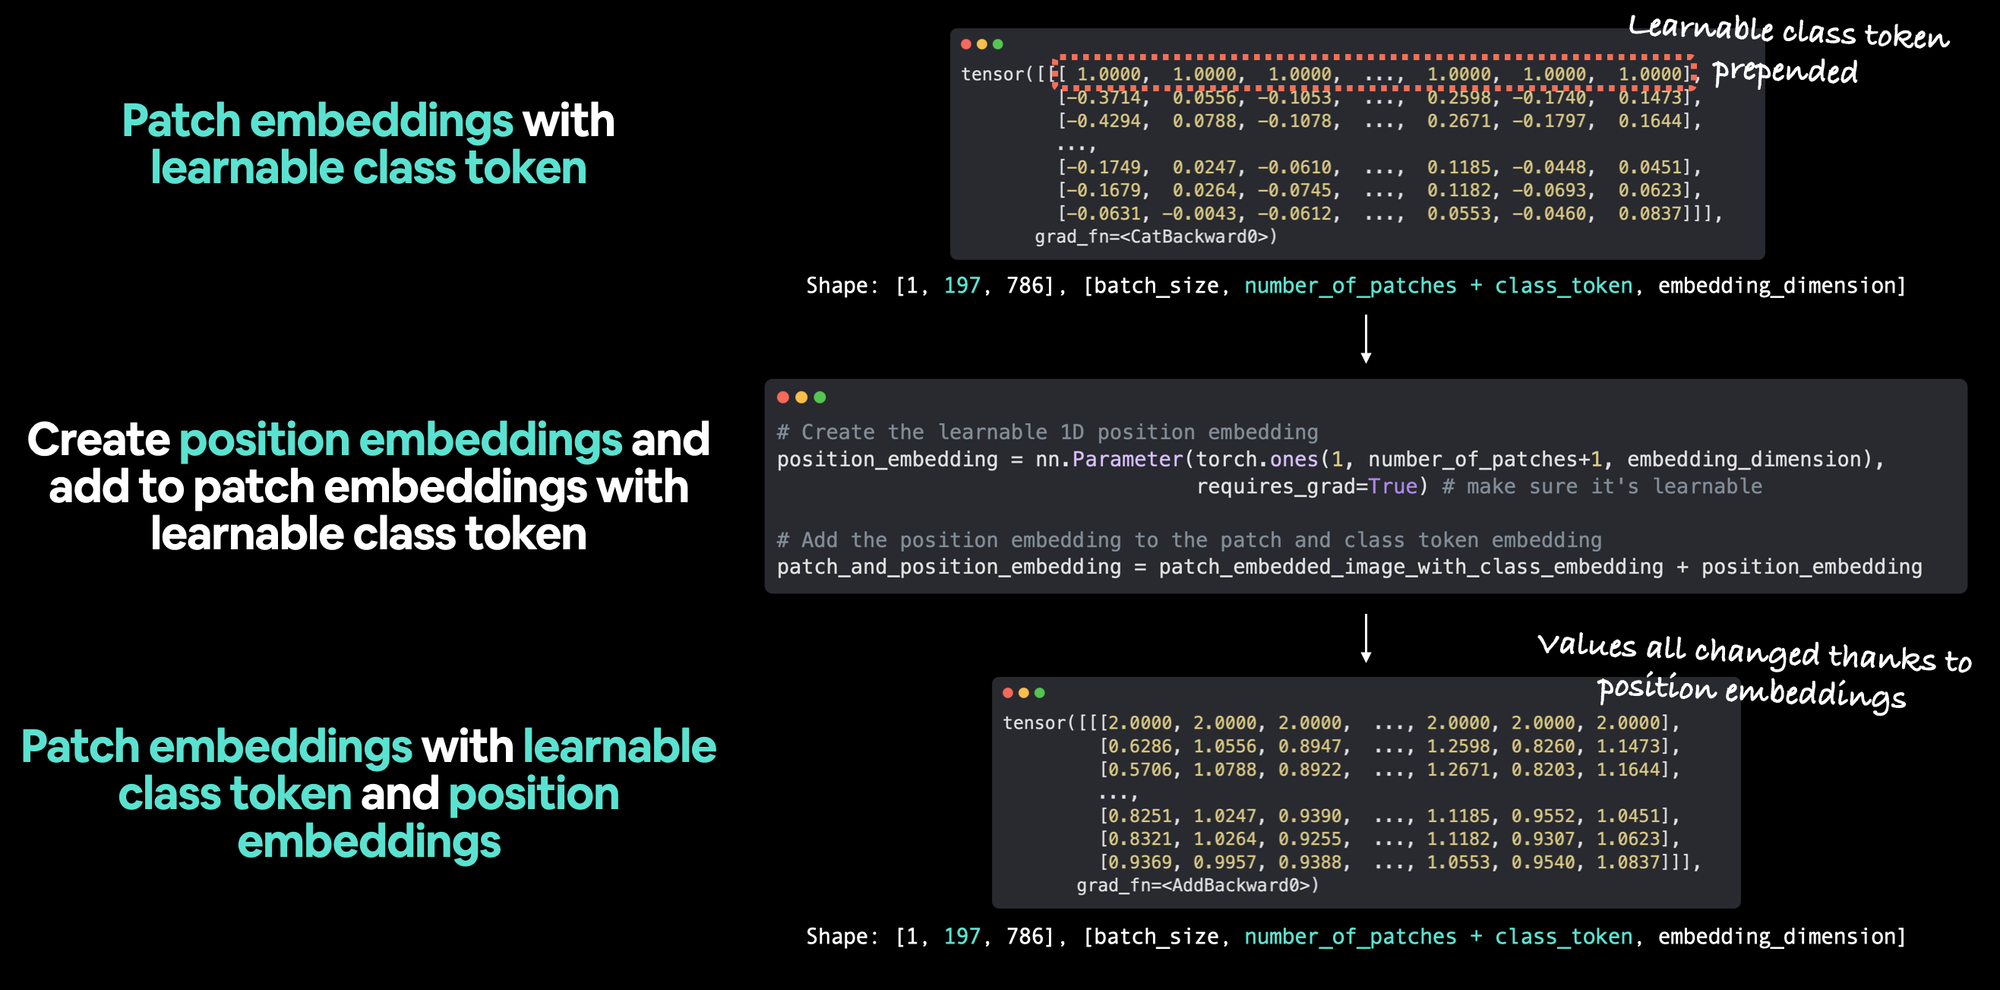

### Putting it all together: from image to embedding

To do:

1. Setting the patch size (we'll use `16` as it's widely used throughout the paper and for ViT-Base).
2. Getting a single image, printing its shape and storing its height and width.
3. Adding a batch dimension to the single image so it's compatible with `PatchEmbedding` layer.
4. Creating a `PatchEmbedding` layer (the one we made in section 4.5) with a `patch_size=16` and `embedding_dim=768` (from Table 1 for ViT-Base).
5. Passing the single image through the `PatchEmbedding` layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding like in section 4.6.
7. Prepending the class token emebdding to the patch embeddings created in step 5.
8. Creating a position embedding like in section 4.7.
9. Adding the position embedding to the class token and patch embeddings created in step 7.

In [29]:
# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### Replicating Equation 2 LayerNorm and MultiheadAttention

To do:
1. Create a class called `MultiheadSelfAttentionBlock` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the `normalized_shape` parameter the same as embedding dimension ($D$ from Table 1).
4. Create a multi-head attention (MSA) layer with the appropriate  `embed_dim`,  `num_heads`,  `dropout` and `batch_first` parameters.
5. Create a `forward()` method for class passing the in the inputs through the `torch.nn.LayerNorm()` and `torch.nn.MultiheadAttention()` layer.

In [30]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

Let's try it out by create an instance of MultiheadSelfAttentionBlockand passing through the patch_and_position_embeddingvariable.

In [31]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1 
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


### Replicating Equation 3: Multilayer Perceptron (MLP)

To do:

1. Create a class called `MLPBlock` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with `torch.nn.LayerNorm()` with the `normalized_shape` parameter the same as embedding dimension ($D$ from Table 1).
4. Create a sequential series of MLP layers(s) using `torch.nn.Linear()`, `torch.nn.Dropout()` and `torch.nn.GELU()` with appropriate hyperparameter values from Table 1 and Table 3.
5. Create a `forward()` method for class passing the in the inputs through the LN layer and MLP layer(s).

In [32]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

Let's try it out by create an instance of MLPBlock and passing through the  patched_image_through_msa_block variable.

In [33]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1 
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


### Create the Transformer Encoder

In the case of the ViT architecture, the residual connection means the input of the MSA block is added back to the output of the MSA block before it passes to the MLP block.

To do:

1. Create a class called `TransformerEncoderBlock` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Instantiate a MSA block for equation 2 using `MultiheadSelfAttentionBlock` from section 5.2 with the appropriate parameters.
4. Instantiate a MLP block for equation 3 using `MLPBlock` from section 6.2 with the appropriate parameters.
5. Create a `forward()` method for `TransformerEncoderBlock` class.
6. Create a residual connection for the MSA block (for equation 2).
7. Create a residual connection for the MLP block (for equation 3).

In [34]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

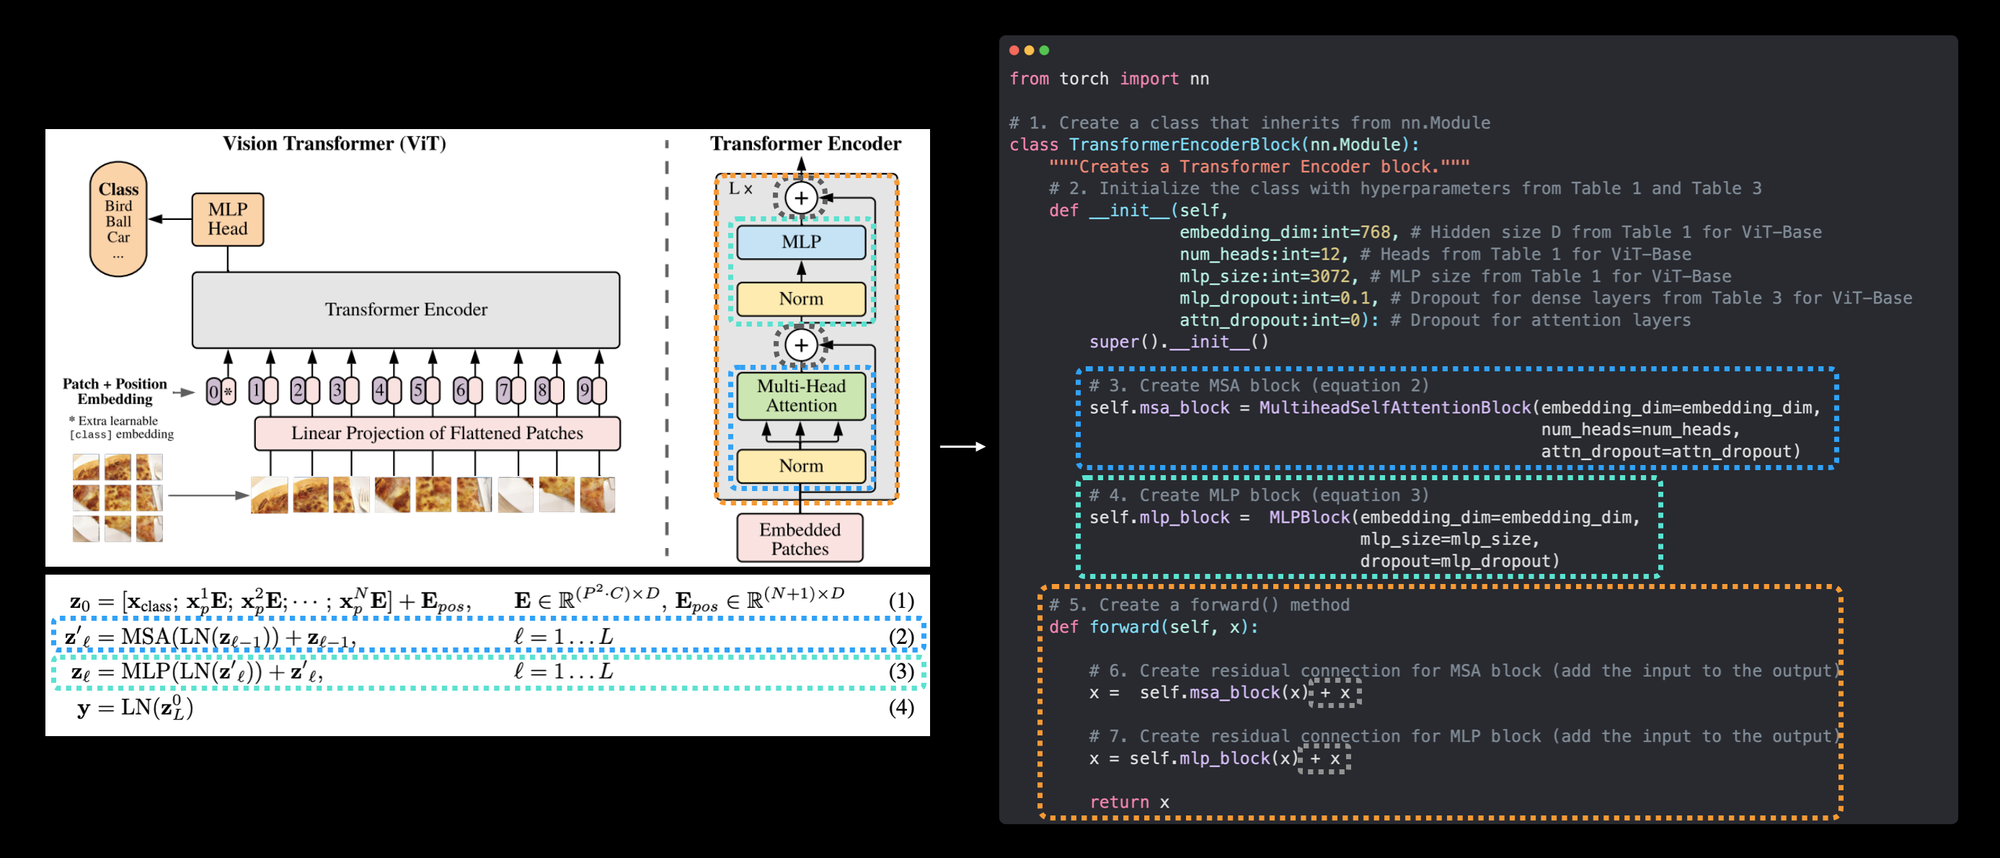

**Get summary of model**

In [35]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Putting it all together to create ViT

Finally, to implementation of ViT:

1. Create a class called `ViT` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Make sure the image size is divisible by the patch size (the image should be split into even patches).
4. Calculate the number of patches using the formula $N=HW/P^2$, where $H$ is the image height, $W$ is the image width and $P$ is the patch size.
5. Create a learnable class embedding token (equation 1).
6. Create a learnable position embedding vector (equation 1).
7. Setup the embedding dropout layer as discussed in Appendix B.1 of the ViT paper.
8. Create the patch embedding layer using the `PatchEmbedding` class.
9. Create a series of Transformer Encoder blocks by passing a list of `TransformerEncoderBlock`s created in section 7.1 to `torch.nn.Sequential()` (equations 2 & 3).
10. Create the MLP head (also called classifier head or equation 4) by passing a `torch.nn.LayerNorm()` (LN) layer and a `torch.nn.Linear(out_features=num_classes)` layer (where `num_classes` is the target number of classes) linear layer to `torch.nn.Sequential()`.
11. Create a `forward()` method that accepts an input.
12. Get the batch size of the input (the first dimension of the shape).
13. Create the patching embedding using the layer (equation 1).
14. Create the class token embedding using the layer created in step 5 and expand it across the number of batches found in step 11 using [torch.Tensor.expand()](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) (equation 1).
15. Concatenate the class token embedding created in step 13 to the first dimension of the patch embedding created in step 12 using [torch.cat()](https://pytorch.org/docs/stable/generated/torch.cat.html) (equation 1).
16. Add the position embedding created in step 6 to the patch and class token embedding created in step 14 (equation 1).
17. Pass the patch and position embedding through the dropout layer.
18. Pass the patch and position embedding from step 16 through the stack of Transformer Encoder layers (equations 2 & 3).
19. Pass index 0 of the output of the stack of Transformer Encoder layers from step 17 through the classifier head (equation 4).

In [36]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

Create a random tensor in the same shape as a single image, pass to an instance of ViT

In [37]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(classes))

# Pass the random image tensor to ViT instance
vit(random_image_tensor)

tensor([[ 0.3282, -0.1277,  0.4795,  0.4543,  0.3912,  0.5842, -0.1331, -0.0401,
         -0.3052,  0.4846]], grad_fn=<AddmmBackward0>)

**Get summary of model**

In [38]:
from torchinfo import summary

# Print a summary of custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 10]             152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

# Setting up and training ViT

## Setting up training code for our ViT model

### Set device

In [39]:
import torch

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(f"Using device is {device}.")

Using device is cuda.


### Instantiation constant variables

In [40]:
import pathlib

DATA_PATH = pathlib.Path('data')
SAVE_MODEL_PATH = pathlib.Path('models/vit_model.pth')
BATCH_SIZE = 8
TRAIN_SIZE = 0.85
TEST_SIZE = 0.15

### Create train and test dataloaders

In [41]:
from utils import make_dataloaders
train_dataloader, test_dataloader, classes, class_to_idx = make_dataloaders(data_path=DATA_PATH,
                                                                           train_size=TRAIN_SIZE,
                                                                           test_size=TEST_SIZE,
                                                                           batch_size=BATCH_SIZE,
                                                                           limit_size=True)
print(f"Length of train_dataloader is {len(train_dataloader)}.\
        \nLength of test_dataloader is {len(test_dataloader)}.")

Length of train_dataloader is 63.        
Length of test_dataloader is 63.


### Instantiation ViT

In [42]:
from engine import ViT

vit = ViT(num_classes=len(classes))

### Creating an optimizer and loss function

In [43]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

### Clear cache

In [44]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Training ViT model

In [45]:
from utils import train
import os

# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"

# Train the model and save the training results to a dictionary
results = train(model=vit,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=20,
                device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9083 | train_acc: 0.1369 | test_loss: 2.4671 | test_acc: 0.1984
Epoch: 2 | train_loss: 2.3571 | train_acc: 0.1508 | test_loss: 2.3410 | test_acc: 0.1647
Epoch: 3 | train_loss: 2.3510 | train_acc: 0.1746 | test_loss: 2.3254 | test_acc: 0.1984
Epoch: 4 | train_loss: 2.2881 | train_acc: 0.1667 | test_loss: 2.2734 | test_acc: 0.1984
Epoch: 5 | train_loss: 2.2758 | train_acc: 0.1806 | test_loss: 2.2409 | test_acc: 0.1984
Epoch: 6 | train_loss: 2.2475 | train_acc: 0.1706 | test_loss: 2.2103 | test_acc: 0.1984
Epoch: 7 | train_loss: 2.2298 | train_acc: 0.1865 | test_loss: 2.2194 | test_acc: 0.1984
Epoch: 8 | train_loss: 2.2178 | train_acc: 0.1905 | test_loss: 2.2276 | test_acc: 0.1647
Epoch: 9 | train_loss: 2.2269 | train_acc: 0.1766 | test_loss: 2.2330 | test_acc: 0.1647
Epoch: 10 | train_loss: 2.2317 | train_acc: 0.1667 | test_loss: 2.2337 | test_acc: 0.1984
Epoch: 11 | train_loss: 2.2316 | train_acc: 0.2004 | test_loss: 2.2347 | test_acc: 0.1984
Epoch: 12 | train_l

### Plot the loss curves of our ViT model

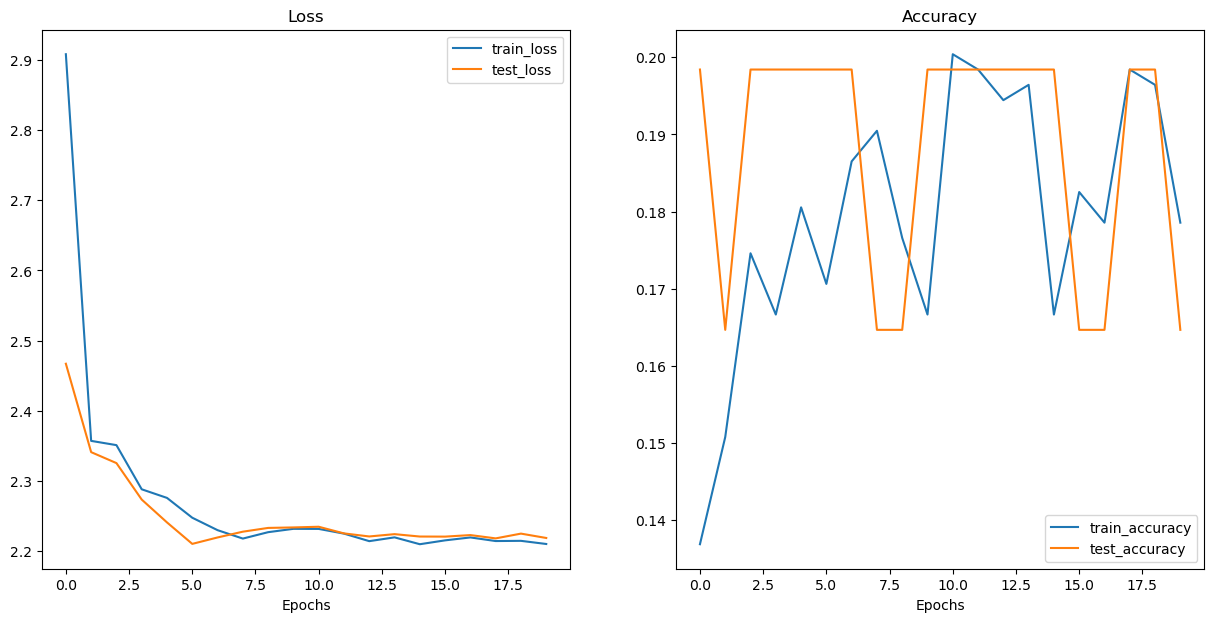

In [46]:
from utils import plot_loss_curves
plot_loss_curves(results)

Model has very bad results, i will use pretrained ViT model

## Save and load model

### Save model

In [47]:
torch.save(vit.state_dict(), SAVE_MODEL_PATH)

### Load model

In [48]:
import torch
from torchinfo import summary

vit_loaded = ViT(num_classes=len(classes))
vit_loaded.load_state_dict(torch.load(SAVE_MODEL_PATH))
summary(vit_loaded)

Layer (type:depth-idx)                                            Param #
ViT                                                               152,064
├─Dropout: 1-1                                                    --
├─PatchEmbedding: 1-2                                             --
│    └─Conv2d: 2-1                                                590,592
│    └─Flatten: 2-2                                               --
├─Sequential: 1-3                                                 --
│    └─TransformerEncoderBlock: 2-3                               --
│    │    └─MultiheadSelfAttentionBlock: 3-1                      2,363,904
│    │    └─MLPBlock: 3-2                                         4,723,968
│    └─TransformerEncoderBlock: 2-4                               --
│    │    └─MultiheadSelfAttentionBlock: 3-3                      2,363,904
│    │    └─MLPBlock: 3-4                                         4,723,968
│    └─TransformerEncoderBlock: 2-5                         

# Setting up and using pretrained ViT model

## Setting up training code for our pretrained ViT model

### Set device

In [49]:
import torch

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(f"Using device is {device}.")

Using device is cuda.


### Instantiation constant variables

In [50]:
import pathlib

DATA_PATH = pathlib.Path('data')
SAVE_PRETRAINED_MODEL_PATH = pathlib.Path('models/pretrained_vit_model.pth')
BATCH_SIZE = 8
TRAIN_SIZE = 0.85
TEST_SIZE = 0.15

### Create train and test dataloaders

In [51]:
from utils import make_dataloaders
train_dataloader, test_dataloader, classes, class_to_idx = make_dataloaders(data_path=DATA_PATH,
                                                                           train_size=TRAIN_SIZE,
                                                                           test_size=TEST_SIZE,
                                                                           batch_size=BATCH_SIZE,
                                                                           limit_size=True)
print(f"Length of train_dataloader is {len(train_dataloader)}.\
        \nLength of test_dataloader is {len(test_dataloader)}.")

Length of train_dataloader is 63.        
Length of test_dataloader is 63.


### Get pretrained weights for ViT-Base

In [52]:
import torchvision

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available

### Setup a ViT model instance with pretrained weights

In [53]:
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

### Freeze the base parameters

In [54]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

### Change the classifier head (set the seeds to ensure same initialization with linear head)

In [55]:
from torch import nn

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(classes)).to(device)

### Summary of model

In [56]:
# Print a summary using torchinfo
from torchinfo import summary
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 10]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### Creating an optimizer and loss function

In [57]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

### Clear cache

In [58]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Train feature extractor ViT model

In [59]:
from utils import train


loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = train(model=pretrained_vit,
                                     train_dataloader=train_dataloader,
                                     test_dataloader=test_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=20,
                                     device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2336 | train_acc: 0.6845 | test_loss: 0.5420 | test_acc: 0.9187
Epoch: 2 | train_loss: 0.3394 | train_acc: 0.9563 | test_loss: 0.3323 | test_acc: 0.9206
Epoch: 3 | train_loss: 0.1922 | train_acc: 0.9742 | test_loss: 0.2677 | test_acc: 0.9345
Epoch: 4 | train_loss: 0.1290 | train_acc: 0.9802 | test_loss: 0.2281 | test_acc: 0.9405
Epoch: 5 | train_loss: 0.0900 | train_acc: 0.9921 | test_loss: 0.2170 | test_acc: 0.9405
Epoch: 6 | train_loss: 0.0682 | train_acc: 0.9940 | test_loss: 0.2007 | test_acc: 0.9405
Epoch: 7 | train_loss: 0.0533 | train_acc: 0.9980 | test_loss: 0.1930 | test_acc: 0.9484
Epoch: 8 | train_loss: 0.0425 | train_acc: 1.0000 | test_loss: 0.1932 | test_acc: 0.9425
Epoch: 9 | train_loss: 0.0349 | train_acc: 0.9980 | test_loss: 0.1873 | test_acc: 0.9425
Epoch: 10 | train_loss: 0.0292 | train_acc: 1.0000 | test_loss: 0.1837 | test_acc: 0.9405
Epoch: 11 | train_loss: 0.0247 | train_acc: 1.0000 | test_loss: 0.1828 | test_acc: 0.9405
Epoch: 12 | train_l

### Plot feature extractor ViT model loss curves

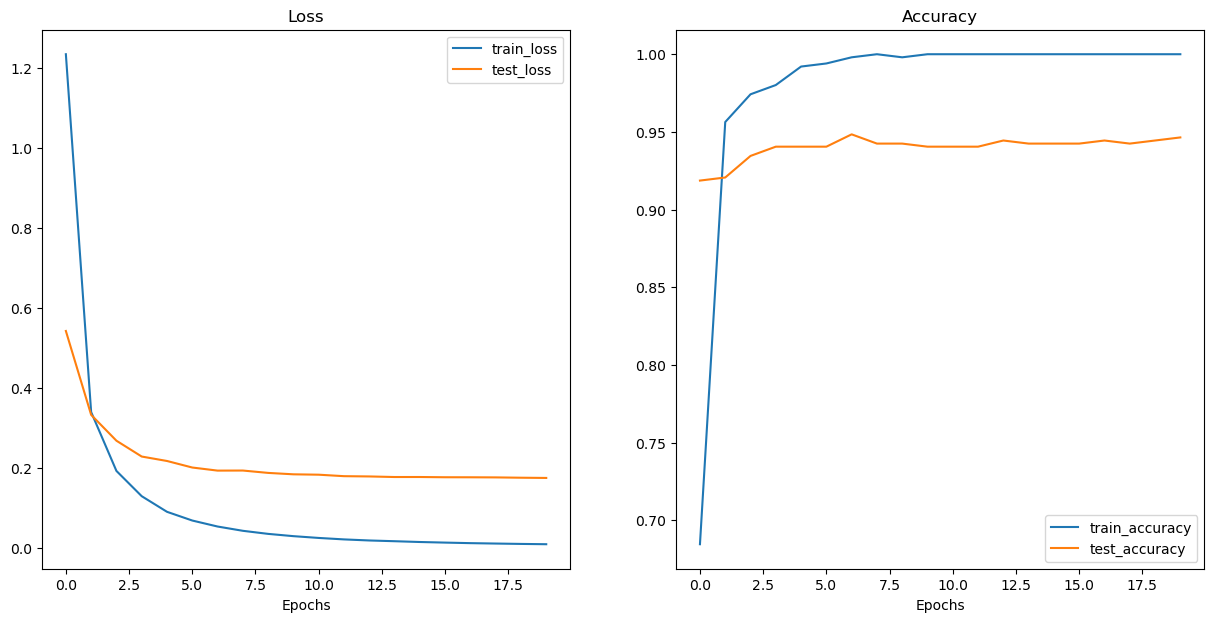

In [60]:
from utils import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

## Save and load model

### Save model

In [61]:
torch.save(pretrained_vit.state_dict(), SAVE_PRETRAINED_MODEL_PATH)

### Load model

In [62]:
import torch
from torch import nn
import torchvision
from torchinfo import summary


# # Get pretrained weights for ViT-Base
# pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" means best available

# Setup a ViT model instance with pretrained weights
pretrained_vit_loaded = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# # Freeze the base parameters
# for parameter in pretrained_vit_loaded.parameters():
#     parameter.requires_grad = False
    
# Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit_loaded.heads = nn.Linear(in_features=768, out_features=len(classes)).to(device)

pretrained_vit_loaded.load_state_dict(torch.load(SAVE_PRETRAINED_MODEL_PATH))
summary(pretrained_vit_loaded)

Layer (type:depth-idx)                                            Param #
VisionTransformer                                                 768
├─Conv2d: 1-1                                                     590,592
├─Encoder: 1-2                                                    151,296
│    └─Dropout: 2-1                                               --
│    └─Sequential: 2-2                                            --
│    │    └─EncoderBlock: 3-1                                     7,087,872
│    │    └─EncoderBlock: 3-2                                     7,087,872
│    │    └─EncoderBlock: 3-3                                     7,087,872
│    │    └─EncoderBlock: 3-4                                     7,087,872
│    │    └─EncoderBlock: 3-5                                     7,087,872
│    │    └─EncoderBlock: 3-6                                     7,087,872
│    │    └─EncoderBlock: 3-7                                     7,087,872
│    │    └─EncoderBlock: 3-8         

### Check on identity weights

In [63]:
pretrained_vit_loaded.state_dict()['heads.weight'][0][0] == pretrained_vit.state_dict()['heads.weight'][0][0]

tensor(True, device='cuda:0')

# Make predictions on custom images

## Set ```IMAGES_SAVE_PATH```

In [64]:
import pathlib

IMAGES_SAVE_PATH = pathlib.Path('test-images')

## Discover images in ```IMAGES_SAVE_PATH```

In [65]:
all_images_path = [i for i in IMAGES_SAVE_PATH.glob('*.*')]
all_images_path

[WindowsPath('test-images/butterfly.jpg'),
 WindowsPath('test-images/cat.jpg'),
 WindowsPath('test-images/chicken.jpg'),
 WindowsPath('test-images/cow.jpg'),
 WindowsPath('test-images/dog.jpg'),
 WindowsPath('test-images/elephant.jpg'),
 WindowsPath('test-images/horse.jpg'),
 WindowsPath('test-images/sheep.jpg'),
 WindowsPath('test-images/spider.jpg'),
 WindowsPath('test-images/squirrel.jpg')]

## Make predictions

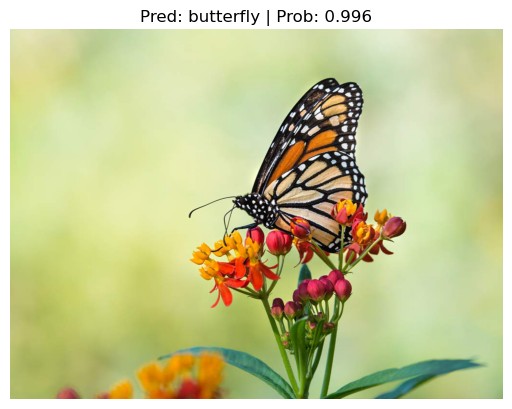

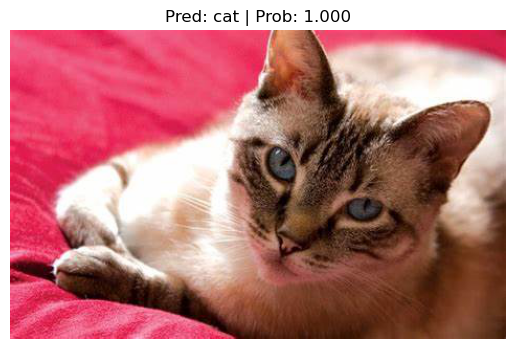

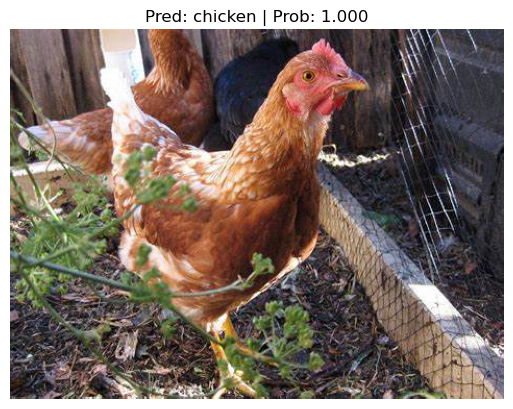

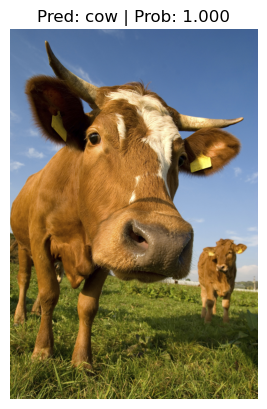

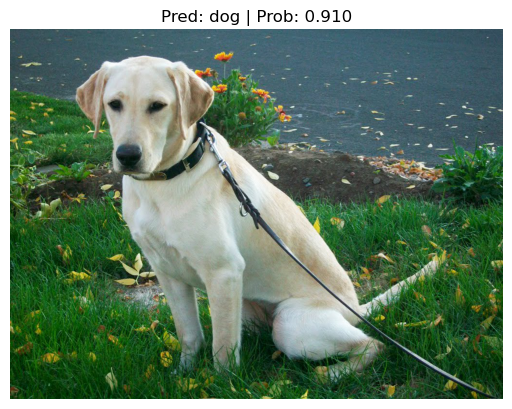

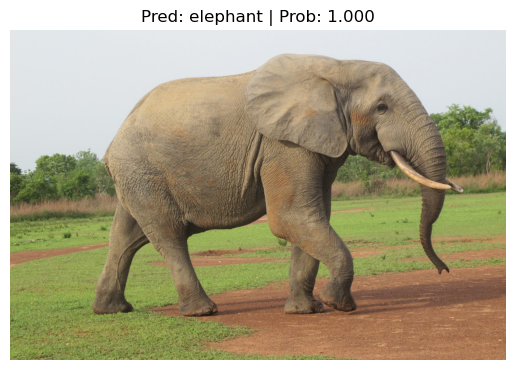

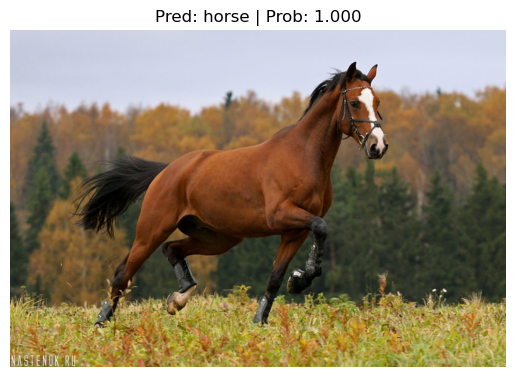

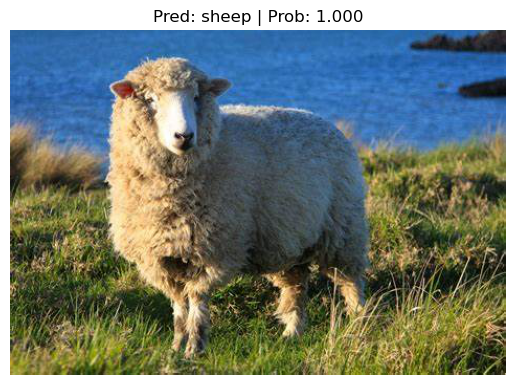

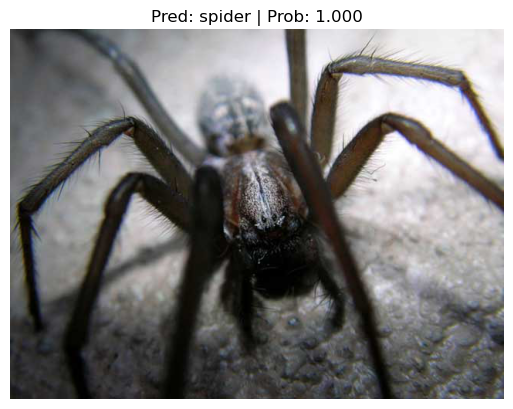

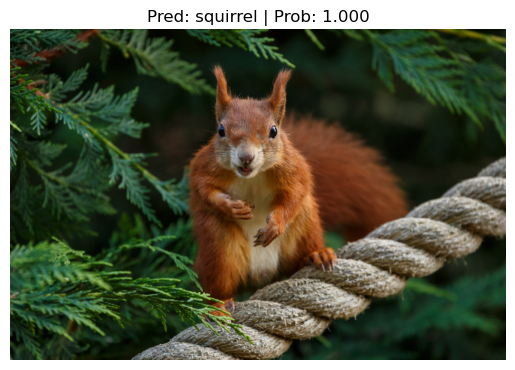

In [67]:
from utils import pred_and_plot_image
for image_path in all_images_path:
    pred_and_plot_image(model=pretrained_vit_loaded,
                       class_names=classes,
                       image_path=image_path,
                       image_size=(224, 224),
                       transform=None,
                       device=device)